### Load MNIST csv files from git

In [2]:
!git clone https://github.com/np2519/mnist.git
# from google.colab import drive
# drive.mount('/content/gdrive')

# How to Deal With Files in Google Colab: Everything You Need to Know
# https://neptune.ai/blog/google-colab-dealing-with-files


# unzip mnist_train.csv.zip
path = "/content/mnist"
# path = "/content/gdrive/MyDrive/Colab Notebooks"

import zipfile
with zipfile.ZipFile(path+'/mnist_train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

Cloning into 'mnist'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 14.78 MiB | 17.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.


### MNIST Digit Classification Example - Create Numpy array
MNIST data source was taken from ... \
https://www.kaggle.com/datasets/oddrationale/mnist-in-csv <br />
https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/ <br />
https://pjreddie.com/projects/mnist-in-csv/

The mnist_train.csv file contains the 60,000 training examples and labels. The mnist_test.csv contains 10,000 test examples and labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

The format is \
label, pix-11, pix-12, pix-13, ...

In [3]:
import numpy as np
import csv

def image_loader(filename, image, label):
    with open(filename) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for id, line in enumerate(csv_reader):
            i, j = 0, 0
            label[id] = line[0]

            i, j, count = (0, 0, 0)
            for pixel in line[1:]:
                i = int(count/28)
                j = count%28
                count += 1
                image[id, i, j] = pixel

train_images = np.empty((60000,28,28))
train_labels = np.empty(60000)

test_images = np.empty((10000,28,28))
test_labels = np.empty(10000)

image_loader(path+'/mnist_train.csv', train_images, train_labels)
image_loader(path+'/mnist_test.csv', test_images, test_labels)

### Test Image Data

(10000,) (10000, 28, 28)
(60000,) (60000, 28, 28)
3.0


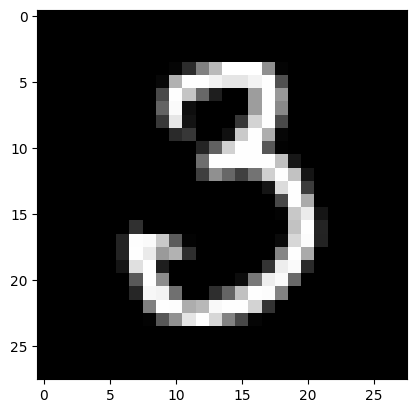

In [ ]:
#test data
import matplotlib.pyplot as plt

print(test_labels.shape, test_images.shape)
print(train_labels.shape, train_images.shape)

# plt.imshow(test_images[1998], cmap='gray', interpolation='none')
plt.imshow(train_images[998], cmap='gray', interpolation='none')
print(train_labels[998])

### Normalization & One-hot encode

In [ ]:
#normalization
import torch
x_train = torch.tensor(train_images.reshape(60000,28*28), dtype=torch.float32)
mean = torch.mean(x_train).item()
std = torch.std(x_train).item()
print(f'mean = {mean:0.2f}, std = {std:0.2f}')

x_test = torch.tensor(test_images.reshape(10000,28*28), dtype=torch.float32)

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

#one-hot endcode
y_train = torch.zeros((60000, 10))
y_test = torch.zeros((10000, 10))

for index, value in enumerate(train_labels):
    y_train[index, int(value)] = 1

for index, value in enumerate(test_labels):
    y_test[index, int(value)] = 1

mean = 33.32, std = 78.57


### Create feedforword neural network

input = 28*28 pixels = 784 linear inputs\
layer1 - fully connects 784 inputs to 25 neurons, activatation function = tanh\
layer2 - fully connects 25 outputs from layer1 to 10 neurons, activation function = sigmoid

In [ ]:
#neural network model
import torch.nn as nn

class Mnist(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(784,25),
            nn.Tanh(),
            nn.Linear(25,10),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear(x)

### Training Setup

In [ ]:
#training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS = 20
LEARNING_RATE = 0.01
BATCH_SIZE = 100

torch.manual_seed(5)
mnist = Mnist()

optimizer = torch.optim.SGD(mnist.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Transfer model to GPU
mnist.to(device)

#initialize weight and bias
for module in mnist.modules():
    if isinstance(module, nn.Linear):
        nn.init.uniform_(module.weight, a=-0.1, b=0.1)
        nn.init.constant_(module.bias, 0.0)

print(mnist)
print('\n' + '-'*100 +'\n')
for param in mnist.parameters():
    print(param)
print('\n' + '-'*100 +'\n')

Mnist(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=25, bias=True)
    (1): Tanh()
    (2): Linear(in_features=25, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

----------------------------------------------------------------------------------------------------

Parameter containing:
tensor([[ 0.0532, -0.0225,  0.0461,  ...,  0.0407,  0.0263,  0.0503],
        [-0.0405, -0.0387,  0.0443,  ..., -0.0199, -0.0250,  0.0535],
        [ 0.0470,  0.0893, -0.0060,  ...,  0.0904,  0.0222,  0.0966],
        ...,
        [-0.0748, -0.0667,  0.0914,  ...,  0.0895,  0.0281,  0.0927],
        [-0.0312,  0.0267, -0.0677,  ..., -0.0433, -0.0281,  0.0635],
        [ 0.0882, -0.0836,  0.0952,  ..., -0.0867,  0.0795,  0.0315]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor

### Create DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageDataSet(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

  def __len__(self):
    return self.labels.shape[0]

train_set = ImageDataSet(x_train, y_train)
test_set = ImageDataSet(x_test, y_test)

train_loader = DataLoader(
    dataset = train_set,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 0
)

test_loader  = DataLoader(
    dataset = test_set,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 0
)


### Training Loop

In [ ]:
for epoch in range(EPOCHS):
    #train data
    correct_train_results = 0

    mnist.train() # Set model in training mode.

    #loop over each batch of BATCH_SIZE images
    for _, (x,y) in enumerate(train_loader):
      # Move data to GPU.
      x, y = x.to(device), y.to(device)
      y_pred = mnist(x)
      loss = loss_fn(y_pred, y)         #total loss of a batch

      #find index with the maximum value which corresponds to the digit number
      pred = torch.argmax(y_pred, dim=1)
      target = torch.argmax(y, dim=1)

      #compare the output of the network with label data of all images from this batch
      #count the number of corrected predictions and add to the total
      mask = pred == target
      correct_train_results += torch.sum(mask).item()

      optimizer.zero_grad()
      #mnist.zero_grad()

      loss.backward()
      optimizer.step()

      # with torch.no_grad():
      #   for param in mnist.parameters():
      #     param -= LEARNING_RATE * param.grad

    #validate with test data
    mnist.eval() # Set model in inference mode.
    correct_test_results = 0
    for _, (x,y) in enumerate(test_loader):
      x, y = x.to(device), y.to(device)
      y_pred = mnist(x)
      loss = loss_fn(y_pred, y)

      pred = torch.argmax(y_pred, dim=1)
      target = torch.argmax(y, dim=1)

      mask = pred == target
      correct_test_results += torch.sum(mask).item()

    train_acc = correct_train_results/len(x_train)
    test_acc = correct_test_results/len(x_test)
    print('epoch no:', epoch, 'train_acc: ', f'{train_acc:6.4f}', 'test_acc', f'{test_acc:6.4f}')

epoch no: 0 train_acc:  0.8577 test_acc 0.9077
epoch no: 1 train_acc:  0.9110 test_acc 0.9206
epoch no: 2 train_acc:  0.9181 test_acc 0.9187
epoch no: 3 train_acc:  0.9232 test_acc 0.9235
epoch no: 4 train_acc:  0.9262 test_acc 0.9234
epoch no: 5 train_acc:  0.9298 test_acc 0.9258
epoch no: 6 train_acc:  0.9316 test_acc 0.9200
epoch no: 7 train_acc:  0.9330 test_acc 0.9316
epoch no: 8 train_acc:  0.9344 test_acc 0.9245
epoch no: 9 train_acc:  0.9356 test_acc 0.9300
epoch no: 10 train_acc:  0.9368 test_acc 0.9229
epoch no: 11 train_acc:  0.9382 test_acc 0.9304
epoch no: 12 train_acc:  0.9390 test_acc 0.9300
epoch no: 13 train_acc:  0.9399 test_acc 0.9323
epoch no: 14 train_acc:  0.9423 test_acc 0.9329
epoch no: 15 train_acc:  0.9425 test_acc 0.9325
epoch no: 16 train_acc:  0.9434 test_acc 0.9307
epoch no: 17 train_acc:  0.9449 test_acc 0.9350
epoch no: 18 train_acc:  0.9443 test_acc 0.9326
epoch no: 19 train_acc:  0.9454 test_acc 0.9324


### Visualize Testing of the Trained MNIST Network

4


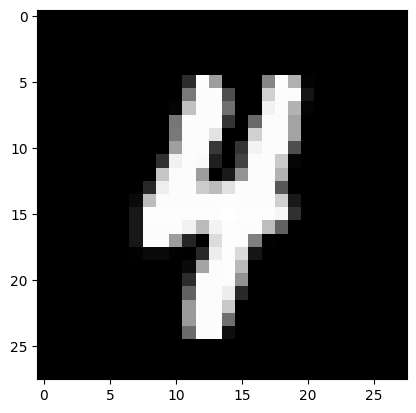

In [ ]:
index = np.random.randint(10000)
y = mnist(x_test[index].to(device))
pred = torch.argmax(y).item()
print(pred)
plt.imshow(test_images[index], cmap='gray', interpolation='none')

In [1]:
torch.save(model.state_dict(), "model.pth")

NameError: name 'torch' is not defined